## Sampling from a langue model 

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dlwbl_eth25/blob/master/notebooks/03_sampling_lmm.ipynb)

The following NB demonstrates the sampling from a causal LLM, like the GPT models.

The idea is to generate a sequence of tokens, one at a time, by sampling from the conditional distribution of the next token given the previous ones. This is done by sampling from the output of the model, which is a probability distribution over the vocabulary.

We start by using very small GTP-2 Models from the `transformers` library of Hugging Face. If you want to use a larger model, you can change the `model_name` to more powerful models.

In [1]:
#load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

import os
os.environ["KERAS_BACKEND"] ="torch"
import keras
import torch
print(f'Keras_version: {keras.__version__}')# 3.5.0
print(f'torch_version: {torch.__version__}')# 2.5.1+cu121
print(f'keras backend: {keras.backend.backend()}')

# Keras Building blocks
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation, Input
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras import optimizers

import time
print(f"CPU available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Keras_version: 3.8.0
torch_version: 2.5.1
keras backend: torch
CPU available: False
Device: cpu


## Selecting the model


In [24]:
from transformers import AutoTokenizer, AutoModelForCausalLM

# Load pretrained model and tokenizer
#model_name = "tiiuae/falcon-7b-instruct" #High mem confing runs ok
model_name = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B" #Quite slow on mac
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B" #For math OK
model_name = "gpt2" #Runs on standard Colab Instances
#model_name = "TinyLlama/TinyLlama_v1.1"

use_quantized_model = False # Works at colab but currently (Feb 2025) need quite some time for installing


## Tokenization

In [25]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
input_context = "Hello World Hund"
torch.tensor(tokenizer.encode(input_context))
# For GPT2 Tokenization
# 15496 is for 'Hello ' note the trailing white space
#  2159 is for ' World' note the leading white space
#   367 is for ' H'
#   917 is for 'und'

tensor([15496,  2159,   367,   917])

### 🔧 **YOUR TASK:**

- Decode the following token ids (gpt-2) coding

In [4]:
ids = torch.tensor([ 8642,   265,  1741,     0,  6733,   317,  3046,    70, 11231,   318, 83, 20383,  9101,   301, 50169,   237])
ids

tensor([ 8642,   265,  1741,     0,  6733,   317,  3046,    70, 11231,   318,
           83, 20383,  9101,   301, 50169,   237])

In [5]:
# @title 🔑 Solution Code { display-mode: "form" }
tokenizer.decode(ids)

'ARYre such! library);\n basg ObservableimtgetMessage danel Changing�'

## Downloading model

In [6]:
if use_quantized_model:
    !pip install bitsandbytes
    !pip install 'accelerate>=0.26.0'

In [7]:
if (use_quantized_model):
    from transformers import BitsAndBytesConfig
    bnb_config = BitsAndBytesConfig(
              load_in_8bit=True,  # Load model in 8-bit precision
              llm_int8_threshold=6.0  # Threshold for quantization
       )
    model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)
else:
    model = AutoModelForCausalLM.from_pretrained(model_name)

model.num_parameters() / (1E9) #In Billions note that GPT 3.5 has 175B


config.json:   0%|          | 0.00/679 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.55G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

1.777088

In [8]:
#model = AutoModelForCausalLM.from_pretrained(model_name)
input_context = "The weather is really nice today. I'm thinking about going for a"
input_ids = torch.tensor(tokenizer.encode(input_context), device=device).unsqueeze(0)
input_ids, input_ids.shape

(tensor([[151646,    785,   9104,    374,   2167,   6419,   3351,     13,    358,
            2776,   7274,    911,   2087,    369,    264]]),
 torch.Size([1, 15]))

## Predicting the next token

In [9]:
start_time = time.time()
outputs = model(input_ids) # We ask the model for the next token
end_time = time.time()

time_next_token = end_time - start_time
print(f"Execution Time: {time_next_token:.3f} seconds")

Execution Time: 0.495 seconds


In [10]:
outputs.logits.shape
# We have 14 entries
# Fhe first are the logits of the next token after 'The'
# The second are the logits of the next token after 'The weather'
# ...
# The last is the next token after 'The weather is really nice today. I'm thinking about going for a'
# This is the only one which matters

torch.Size([1, 15, 151936])

In [11]:
with torch.no_grad():
    next_token_logits = outputs.logits[:, -1, :]
next_token_logits.shape, next_token_logits

(torch.Size([1, 151936]),
 tensor([[ 4.4666,  2.6042, -0.3994,  ..., -2.1347, -2.1343, -2.1347]],
        requires_grad=True))

In [12]:
probs = torch.nn.functional.softmax(next_token_logits, dim=-1)[0]
probs, probs.shape

(tensor([4.1558e-06, 6.4540e-07, 3.2016e-08,  ..., 5.6459e-09, 5.6483e-09,
         5.6460e-09], grad_fn=<SelectBackward0>),
 torch.Size([151936]))

In [13]:
# Find the indices that would sort the probabilities in descending order
sorted_indices = torch.argsort(probs, dim=-1, descending=True)
top_indices = sorted_indices[:10]

cumulative_prob = 0
for index in top_indices:
  token = tokenizer.decode(index.item())
  probability = probs[index].item()
  cumulative_prob += probability
  print(f"Token: '{token}', Probability: {probability}, Cummulative: {cumulative_prob}")

Token: ' walk', Probability: 0.7761977314949036, Cummulative: 0.7761977314949036
Token: ' trip', Probability: 0.032332319766283035, Cummulative: 0.8085300512611866
Token: ' long', Probability: 0.020836569368839264, Cummulative: 0.8293666206300259
Token: '...
', Probability: 0.014605040661990643, Cummulative: 0.8439716612920165
Token: '
', Probability: 0.014055178500711918, Cummulative: 0.8580268397927284
Token: '...', Probability: 0.011412577703595161, Cummulative: 0.8694394174963236
Token: ' hike', Probability: 0.011256502009928226, Cummulative: 0.8806959195062518
Token: ' drive', Probability: 0.009733778424561024, Cummulative: 0.8904296979308128
Token: ' ride', Probability: 0.0067239427007734776, Cummulative: 0.8971536406315863
Token: ' stroll', Probability: 0.006140855606645346, Cummulative: 0.9032944962382317


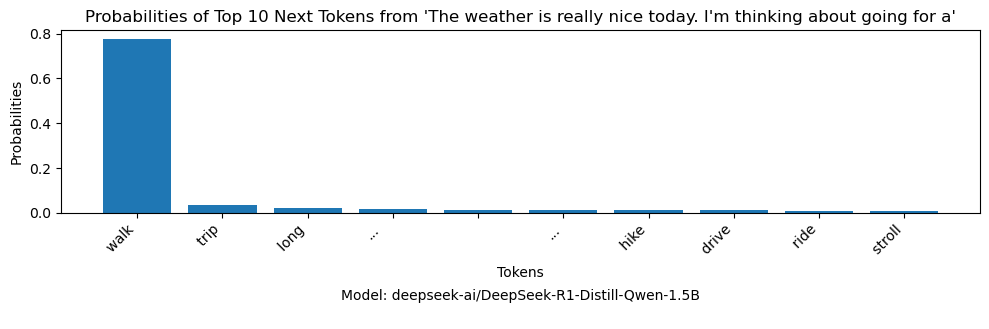

In [14]:
import matplotlib.pyplot as plt
top_indices = sorted_indices[:10]

tokens = []
probabilities = []
for index in top_indices:
  token = tokenizer.decode(index.item())
  probability = probs[index].item()
  tokens.append(token)
  probabilities.append(probability)


# 
# Add dataset information as text within the plot
text_info = f"Model: {model_name}\n"
text_info


plt.figure(figsize=(10, 3))
plt.bar(tokens, probabilities)
plt.xlabel("Tokens")
plt.ylabel("Probabilities")
plt.title(f"Probabilities of Top 10 Next Tokens from '{input_context}'")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.text(0.5, -0.5, text_info, ha='center', va='center', transform=plt.gca().transAxes)  # Adjust position as needed
plt.show()


## Sampling a sequence

### Basic Idea to sample t

In [15]:
from torch.distributions import Categorical
from collections import Counter

# Create a categorical distribution based on the logits
categorical_dist = Categorical(logits=next_token_logits)

# Sample from the distribution
sampled_index = categorical_dist.sample()

# Decode the sampled index to get the actual token
sampled_token = tokenizer.decode(sampled_index.item())
print("Sampled token:", sampled_token)

Sampled token:  long


In [16]:
sampled_tokens = []
for _ in range(100):
    sampled_index = categorical_dist.sample()
    sampled_token = tokenizer.decode(sampled_index.item())
    sampled_tokens.append(sampled_token)

# Create a frequency table
frequency_table = Counter(sampled_tokens)

# Sort the frequency table by frequency in descending order
sorted_frequency_table = dict(sorted(frequency_table.items(), key=lambda item: item[1], reverse=True))

# Display the top-5 frequencies
for token, freq in list(sorted_frequency_table.items())[:10]:
    print(f"Token: '{token}', Frequency: {freq}")

Token: ' walk', Frequency: 78
Token: ' trip', Frequency: 5
Token: '...', Frequency: 2
Token: ' long', Frequency: 2
Token: ' ride', Frequency: 1
Token: ' pizza', Frequency: 1
Token: ' rest', Frequency: 1
Token: '命', Frequency: 1
Token: '...
', Frequency: 1
Token: ')("', Frequency: 1


In [17]:
# Function to apply top-k, top-p, and min-p filtering
def filter_logits(logits, top_k=-1, top_p=2.0, min_p=0.0):
    logits = logits.clone()

    # Apply top-k: Keep only the top k logits
    if top_k > 0:
        top_k_values, _ = torch.topk(logits, top_k)
        min_top_k_logit = top_k_values[:, -1].unsqueeze(-1)
        logits[logits < min_top_k_logit] = -float('Inf')

    # Apply top-p (nucleus sampling)
    if top_p < 1.0:
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        cumulative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=-1)
        sorted_indices_to_remove = cumulative_probs > top_p
        if sorted_indices_to_remove[:, 0].any():
            sorted_indices_to_remove[:, 1:] = sorted_indices_to_remove[:, :-1].clone()
            sorted_indices_to_remove[:, 0] = False
        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
        logits[indices_to_remove] = -float('Inf')

    # Apply min-p: Remove tokens below a minimum probability
    probs = torch.softmax(logits, dim=-1)
    logits[probs < min_p] = -float('Inf')

    return logits

In [23]:
from IPython.display import display, Markdown, clear_output
# Input context
input_context = "What is seq(1,10,0.1) in python"
input_context = "x^16/x^4"
input_context = "The weather is really nice today. I'm thinking about going for a"
input_context = "What is good enough in Chinese, give charaters and Pinyin"
input_context = "What is the capital of France?"
input_context = "Solve for  x  in the equation  2x + 5 = 13 ." #Works with DeepSeek-R1-Distill-Qwen-1.5B


# Typical settings for temperature, top-k, top-p, and min-p
temperature = 0.7
top_k=50
top_p=0.95
min_p=0.01

# No temperature scaling and no filtering
# temperature = 0.7
# top_k=-50
# top_p=100
# min_p=0.0

input_ids = torch.tensor(tokenizer.encode(input_context), device=device).unsqueeze(0)
# EOS token ID
eos_token_id = tokenizer.eos_token_id
print(f"EOS Token ID: {eos_token_id}")

# Function to sample the next token
def sample_next_token(input_ids):
    with torch.no_grad():  # Disable gradient calculation for evaluation
        outputs = model(input_ids)
    next_token_logits = outputs.logits[:, -1, :]

    # Deterministic (greedy) decoding if temperature is 0
    if temperature == 0.0:
        sampled_index = torch.argmax(next_token_logits, dim=-1)
        return sampled_index.item()

    # Apply temperature scaling
    scaled_logits = next_token_logits / temperature

    # Apply top-k, top-p, and min-p filtering
    filtered_logits = filter_logits(scaled_logits, top_k=top_k, top_p=top_p, min_p=min_p)

    # Sample from the filtered distribution
    categorical_dist = Categorical(logits=filtered_logits)
    sampled_index = categorical_dist.sample()

    return sampled_index.item()

# Generate text until EOS token is reached
generated_text = input_context
new_text = "" 
num_tokens_to_generate = 50  # Max tokens to generate if EOS not encountered

start_time = time.time()
for i in range(num_tokens_to_generate):
    sampled_token_index = sample_next_token(input_ids)

    if sampled_token_index == eos_token_id:
        display("\n[End of Sequence Token Generated]")
        break

    sampled_token = tokenizer.decode([sampled_token_index], clean_up_tokenization_spaces=True)

    clear_output(wait=True)
    display(f"{i + 1}. Next token: {sampled_token_index} '{sampled_token}'")
    display(f"{generated_text + sampled_token}")
    
    generated_text += sampled_token
    new_text += sampled_token
    
    input_ids = torch.cat([input_ids, torch.tensor([[sampled_token_index]], device=device)], dim=1)

    

print("\nFinal Generated Text:\n", generated_text, f" {i} tokens in {time.time() - start_time:.3f} seconds")


"50. Next token: 311 ' to'"

'Solve for  x  in the equation  2x + 5 = 13 . (Think of x as a number)\nOkay, so I need to solve the equation 2x + 5 = 13. Hmm, let me think about how to approach this. I remember that to solve for x, I need to'


Final Generated Text:
 Solve for  x  in the equation  2x + 5 = 13 . (Think of x as a number)
Okay, so I need to solve the equation 2x + 5 = 13. Hmm, let me think about how to approach this. I remember that to solve for x, I need to  49 tokens in 15.583 seconds


In [22]:
from IPython.display import display, Markdown

output_text = f"""
**Model:** {model_name}  

**Temperature:** {temperature}

**Top-K:** {top_k}  

**Top-P:** {top_p}  

**Min-P:** {min_p}

<hr/>

**Prompt:** <span style="color:green">{input_context}</span>  

**Generated Text:**  
{new_text}
"""

display(Markdown(output_text))


**Model:** deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B  

**Temperature:** 0.7

**Top-K:** 50  

**Top-P:** 0.95  

**Min-P:** 0.01

<hr/>

**Prompt:** <span style="color:green">What is the capital of France?</span>  

**Generated Text:**  
 And what is the capital of Italy?

I need to provide a response in English, but I can choose to write in either English or French. Should I write in English or French?

I will only use the first response if I'm confused. But


### 🔧 **YOUR TASK:**

- Change the temperature to different values what do you observe? Also change the prompt to e.g. "What is the capital of France."

- If time, change model to a more powerfull model like: 'deepseek-ai/DeepSeek-R1-Distill-Llama-8B'

### Bonus Visualization of the Embedding 🌟✨

Note that the embeddings work with GPT-2 but not with all other models.

In [125]:
# Function to get static embeddings from the embedding layer
def get_static_embeddings(input_ids):
    # Access the embedding layer directly
    with torch.no_grad():
        static_embeddings = model.transformer.wte(input_ids)
    
    return static_embeddings.squeeze(0)  # Shape: [sequence_length, hidden_size]

# Example usage
text = "Data science and deep learning"
static_embeddings = get_static_embeddings(torch.tensor([1,2,3], device=device))
print(static_embeddings[0,0:5])
get_static_embeddings(torch.tensor([2,1,3],device=device))[1,0:5]


tensor([ 0.0403, -0.0486,  0.0462, -0.0990,  0.0826])


tensor([ 0.0403, -0.0486,  0.0462, -0.0990,  0.0826])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


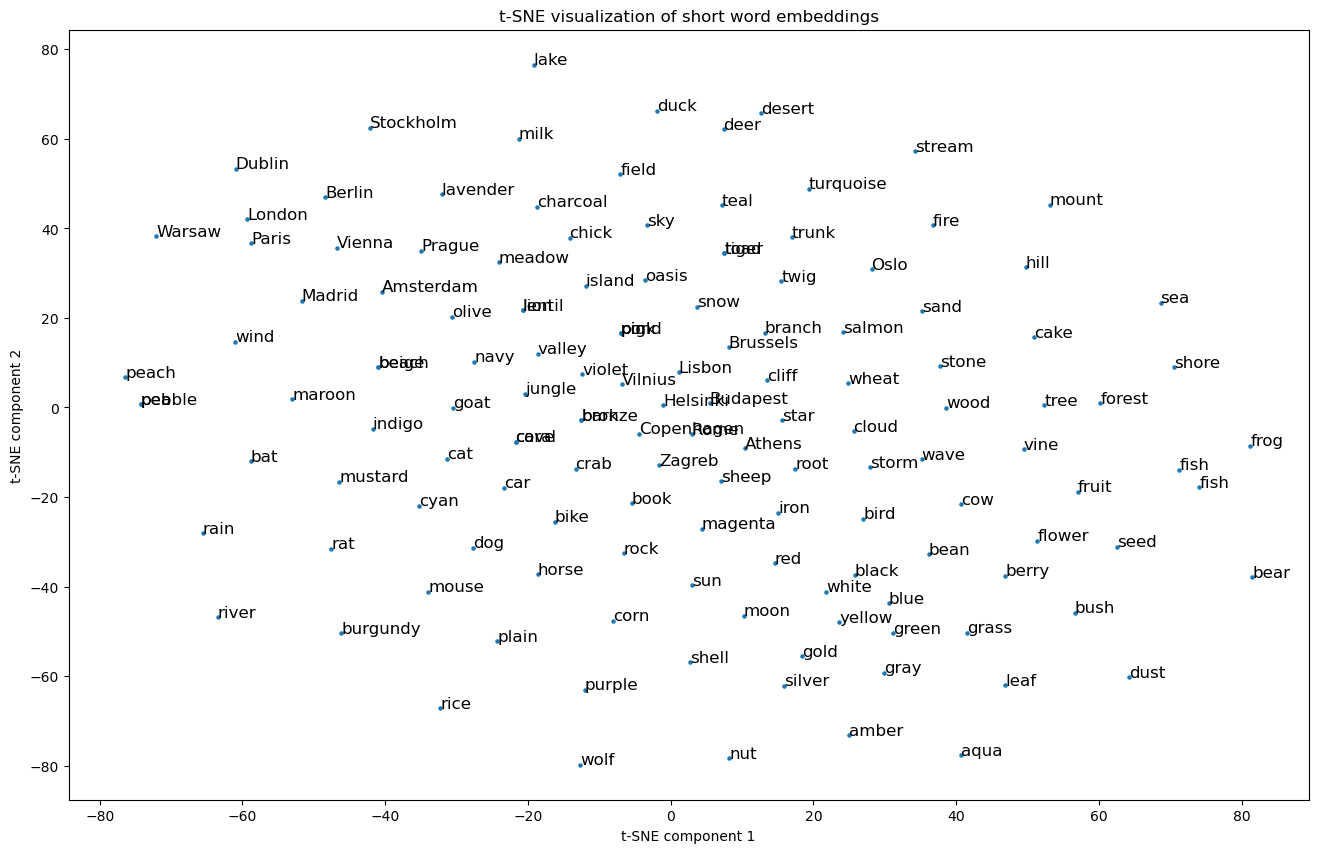

In [126]:
from sklearn.manifold import TSNE
words = [
    "cat", "dog", "fish", "bird", "tree", "book", "car", "bike", "milk", "cake",
    "rain", "snow", "wind", "fire", "star", "moon", "sun", "sky", "blue", "red",
    "green", "yellow", "black", "white", "pink", "gray", "gold", "silver", "bronze",
    "iron", "wood", "rock", "sand", "dust", "cloud", "storm", "wave", "sea", "lake",
    "pond", "river", "stream", "hill", "mount", "valley", "plain", "field", "meadow",
    "forest", "jungle", "desert", "oasis", "island", "beach", "shore", "cliff", "cave",
    "stone", "pebble", "shell", "leaf", "flower", "grass", "bush", "vine", "root",
    "branch", "twig", "bark", "trunk", "seed", "fruit", "berry", "nut", "corn", "wheat",
    "rice", "bean", "pea", "lentil", "chick", "duck", "goat", "sheep", "cow", "horse",
    "pig", "deer", "bear", "wolf", "lion", "tiger", "mouse", "rat", "bat", "frog",
    "toad", "crab", "fish",

    # 20 European Capitals
    "London", "Paris", "Berlin", "Rome", "Madrid", "Lisbon", "Vienna", "Prague",
    "Budapest", "Warsaw", "Athens", "Copenhagen", "Helsinki", "Stockholm", "Oslo",
    "Brussels", "Amsterdam", "Dublin", "Vilnius", "Zagreb",

    # Additional Colors
    "purple", "turquoise", "navy", "maroon", "beige", "cyan", "magenta", "lavender",
    "teal", "olive", "amber", "indigo", "coral", "aqua", "violet", "burgundy",
    "charcoal", "mustard", "peach", "salmon"
]

# Get embeddings for the filtered short words
short_word_embeddings = []
for word in words:
    token_id = tokenizer.encode(word, add_special_tokens=False)[0]
    embedding = get_static_embeddings(torch.tensor([token_id], device=device))
    short_word_embeddings.append(embedding.cpu().numpy())

# Convert to numpy array
short_word_embeddings = np.array(short_word_embeddings).squeeze()

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(short_word_embeddings)

# Plot the results
plt.figure(figsize=(16, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=5)

# Annotate the points with the words
for i, word in enumerate(words):
    plt.annotate(word, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=12)

plt.title("t-SNE visualization of short word embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()